In [251]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [252]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
#df.describe(include="all").T
df.head(2)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product


### Exploratory Data Analysis (EDA) 
EDA is going to help us inanalyzing and summarizing our data set's main characteristics. Also, to identify underlying structure of our data, to spot anomalies and outliers, to test underlying assumptions, and to form hypotheses that can be further tested.

In [253]:
# Construct Target by adding salary and bonus. 
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)
df.head()

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
3,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0
4,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",29,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0


In [254]:
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

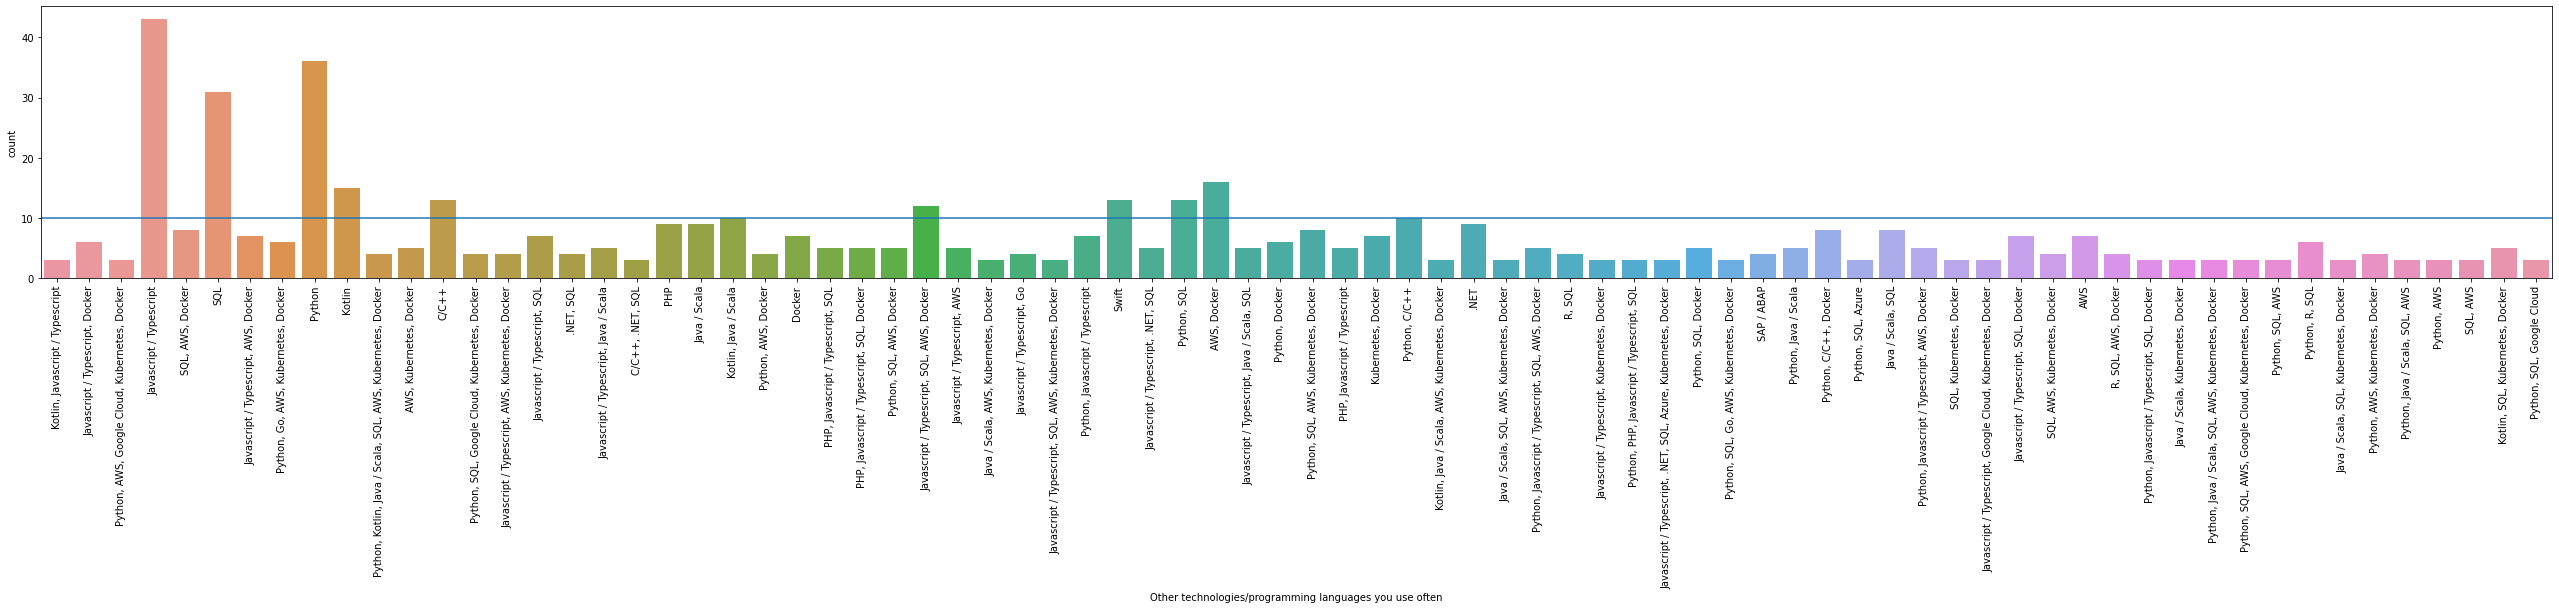

In [255]:
# Construct a temporary dataset with things that have > 2 records
# remove outliers
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df_tmp[df_tmp["target"] < 250000]

plt.figure(figsize=(45,5))
ax = sns.countplot(x="Other technologies/programming languages you use often", data=df_tmp)
ax.axhline(10)
ax.tick_params(axis='x', rotation=90)

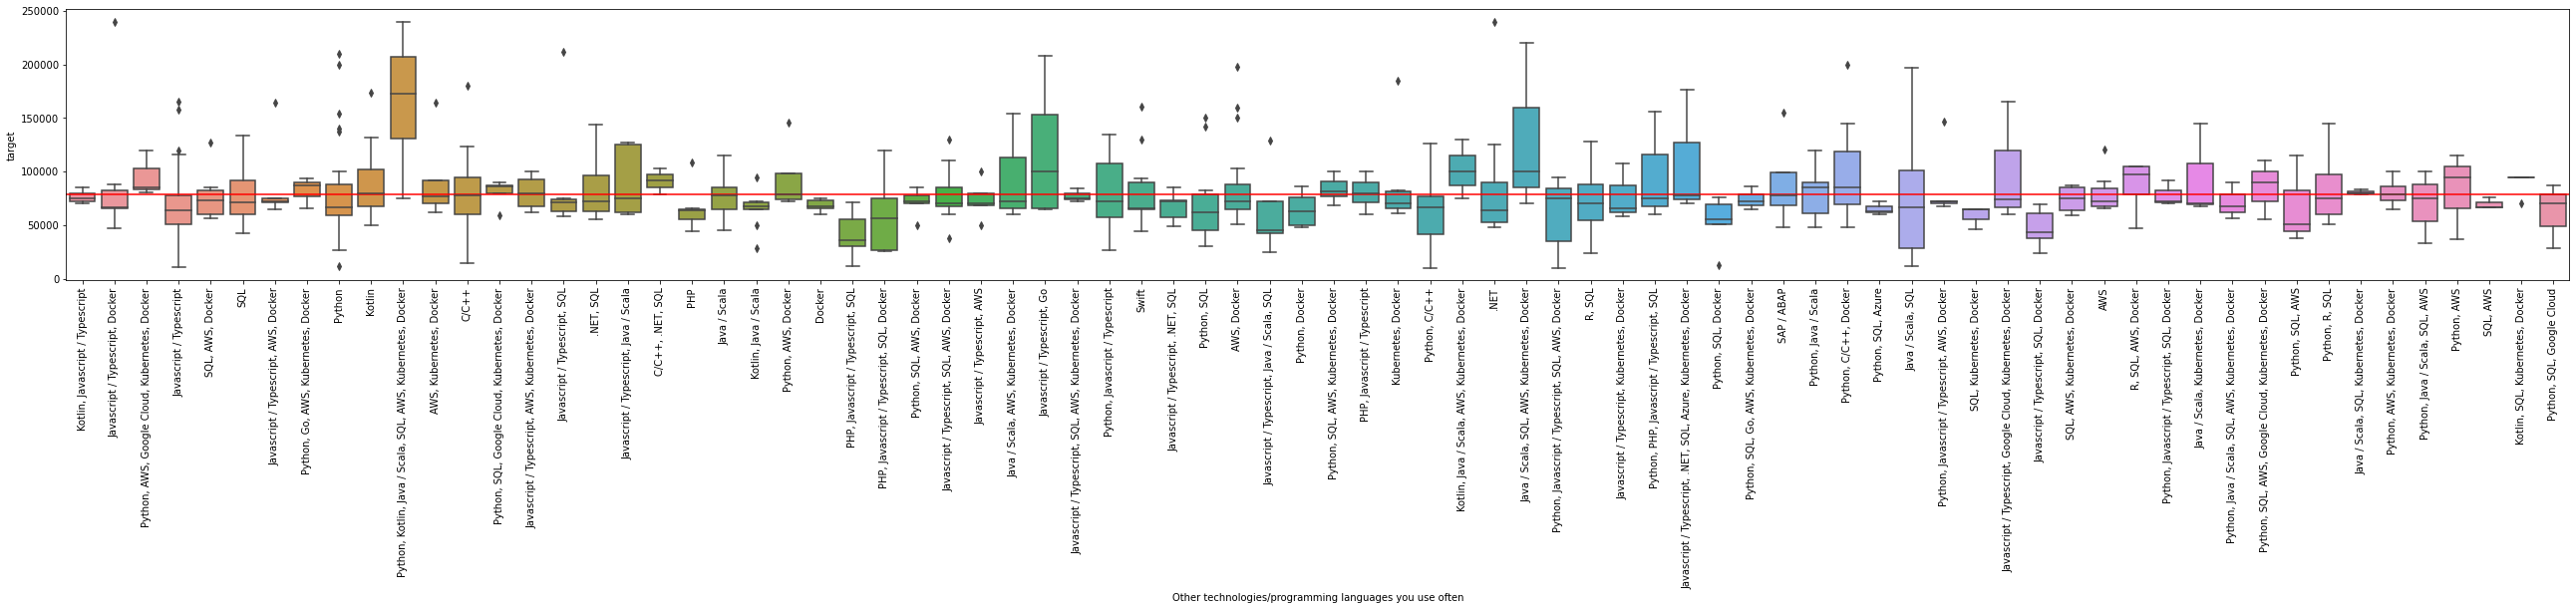

In [256]:
plt.figure(figsize=(45,5))
ax = sns.boxplot(x="Other technologies/programming languages you use often", y="target", data=df_tmp)
ax.axhline(df_tmp["target"].mean(), color="red")
ax.tick_params(axis='x', rotation=90)

In [257]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [258]:
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 10, "Other")
df["Your main technology / programming language"].value_counts()

Other         377
Java          184
Python        164
PHP            56
C++            38
JavaScript     34
Javascript     31
C#             30
python         26
Swift          24
Scala          24
Go             23
Kotlin         22
Python         21
Ruby           19
TypeScript     14
SQL            14
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1226 non-null   float64
 1   Gender                                                  1243 non-null   object 
 2   City                                                    1253 non-null   object 
 3   Position                                                1247 non-null   object 
 4   Total years of experience                               1237 non-null   object 
 5   Years of experience in Germany                          1221 non-null   object 
 6   Seniority level                                         1241 non-null   object 
 7   Your main technology / programming language             1126 non-null   object 
 8   Other technologies/programming languag

In [260]:
## Correlation Matrix
corr = df.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

C:\Users\shikh\AppData\Local\Temp\ipykernel_12992\527883699.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient().set_precision(2)


,Age,target
Age,1.00,-0.02
target,-0.02,1.00


In [261]:
df.describe()

,Age,target
count,1226.000000,1.253000e+03
mean,32.509788,8.428361e+07
std,5.663804,2.829182e+09
min,20.000000,1.000100e+04
25%,29.000000,6.000000e+04
50%,32.000000,7.400000e+04
75%,35.000000,9.100000e+04
max,69.000000,1.000000e+11


### Identifying numerical and categorical variables 
It is an important step in the data preprocessing and analysis phase because:
<br>
<br>Data Preparation: Numerical variables may require scaling, while categorical variables need to be one-hot encoded before they can be used as inputs to the model.

<br>Exploratory Data Analysis: Identifying numerical and categorical variables can help in understanding the structure and distribution of the data, and identify any potential outliers or anomalies.

<br>Feature Selection: Numerical and categorical variables may have different feature importances in or model, and this information can be used to select relevant features.

<br >Model Selection: For correct model selection.For example, decision trees and random forests are commonly used for categorical data, while linear regression is used for numerical data.

In [262]:
def find_categorical_numerical(df):
    categorical = []
    numerical = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical.append(col)
        else:
            numerical.append(col)
    return categorical, numerical

In [263]:
categorical, numerical = find_categorical_numerical(df)

In [264]:
# Categorical data is 


print("categorical Data:")
categorical

categorical Data:


['Gender',
 'City',
 'Position ',
 'Total years of experience',
 'Years of experience in Germany',
 'Seniority level',
 'Your main technology / programming language',
 'Other technologies/programming languages you use often',
 'Number of vacation days',
 'Employment status',
 'Сontract duration',
 'Main language at work',
 'Company size',
 'Company type']

In [265]:
# Numerical data is :


print("Numerical data:")
numerical

Numerical data:


['Age', 'target']

In [266]:
df.sample(10)

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,target
1083,28.0,Female,Berlin,Designer (UI/UX),5,1,Senior,NaN,NaN,26,Full-time employee,Unlimited contract,English,1000+,Consulting / Agency,60000.0
420,31.0,Female,Munich,Software Engineer,2,2,Middle,Java,SQL,28,Full-time employee,Unlimited contract,German,1000+,Product,61000.0
684,25.0,Male,Berlin,Software Engineer,6,3,Senior,Other,"AWS, Docker",30,Full-time employee,Unlimited contract,English,1000+,Product,77750.0
401,39.0,Male,Stuttgart,Software Engineer,11,3,Lead,PHP,"PHP, SQL, Kubernetes, Docker",30,Full-time employee,Unlimited contract,English,101-1000,Product,75000.0
337,47.0,Male,Hamburg,Software Engineer,22,10,Senior,Other,"C/C++, .NET, SQL",30,Full-time employee,Unlimited contract,English,up to 10,Product,92000.0
518,39.0,Male,Berlin,Data Scientist,7,4,Senior,Other,"Python, SQL, AWS, Docker, unix shell scripts",28,Full-time employee,Unlimited contract,English,101-1000,Startup,140000.0
167,28.0,Male,Moldova,Backend Developer,4,0,Middle,Other,"Kotlin, Java / Scala",NaN,NaN,NaN,English,51-100,Startup,28000.0
390,25.0,Male,Berlin,Backend Developer,5,0,Middle,Java,"Python, Kotlin, Java / Scala, SQL, AWS, Google...",30,Full-time employee,Unlimited contract,English,1000+,Startup,80000.0
359,33.0,Male,Berlin,Software Engineer,13,3,Senior,Ruby,"Ruby, Java / Scala, Go, AWS, Kubernetes, Docker",27,Full-time employee,Unlimited contract,English,1000+,Product,95000.0
899,35.0,Male,Berlin,Frontend Developer,6,1,Middle,Other,Javascript / Typescript,27,Full-time employee,Unlimited contract,English,1000+,Product,66500.0


In [267]:
df.drop(df.index[(df["Number of vacation days"] == "unlimited")],axis=0,inplace=True)

In [268]:
[df['Number of vacation days']=='unlimited']


[0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 1248    False
 1249    False
 1250    False
 1251    False
 1252    False
 Name: Number of vacation days, Length: 1250, dtype: bool]

In [269]:
df['Number of vacation days'] = df['Number of vacation days'].apply(pd.to_numeric, downcast='float', errors='coerce')

In [270]:
df['Total years of experience'] = df['Total years of experience'].apply(pd.to_numeric, downcast='float', errors='coerce')

In [271]:
df['Years of experience in Germany'] = df['Years of experience in Germany'].apply(pd.to_numeric, downcast='float', errors='coerce')

In [272]:
print("Numerical data:")
numerical

Numerical data:


['Age', 'target']

In [273]:
print("categorical Data:")
categorical

categorical Data:


['Gender',
 'City',
 'Position ',
 'Total years of experience',
 'Years of experience in Germany',
 'Seniority level',
 'Your main technology / programming language',
 'Other technologies/programming languages you use often',
 'Number of vacation days',
 'Employment status',
 'Сontract duration',
 'Main language at work',
 'Company size',
 'Company type']

In [274]:
#Defining outliers
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in numerical:
    print(col, check_outlier(df, col))
#person_age, person_income and person_emp_lenght have some outlier observations

Age False
target True


In [275]:
outlier_thresholds(df, numerical)

(Age          -16.0
 target   -382505.0
 dtype: float64,
 Age           88.0
 target    696175.0
 dtype: float64)

### Finding nan's in our dataset:
The presence of NaN values can impact the accuracy and reliability of the results of any analysis or modeling performed on the dataset. It is therefore important to handle missing values appropriately, either by imputing the missing values or removing the observations with missing values.

df.isna().sum()
#Replacing Outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > (up_limit-150000)), variable] = up_limit

for col in numerical:
    replace_with_thresholds(df, col)

#Check
for col in numerical:
    print(col, check_outlier(df, col))

In [276]:
df.isna().sum()
#Replacing Outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > (up_limit)), variable] = up_limit

for col in numerical:
    replace_with_thresholds(df, col)

#Check
for col in numerical:
    print(col, check_outlier(df, col))

Age False
target False


In [277]:
df.describe()

,Age,Total years of experience,Years of experience in Germany,Number of vacation days,target
count,1224.000000,1227.000000,1191.000000,1172.000000,1250.000000
mean,32.501634,9.072616,3.754828,28.348549,86072.504464
std,5.664510,11.911489,3.659936,10.759972,57241.413433
min,20.000000,0.000000,0.000000,0.000000,10001.000000
25%,29.000000,5.000000,1.000000,27.000000,60000.000000
50%,32.000000,8.000000,3.000000,28.000000,73750.000000
75%,35.000000,12.000000,5.000000,30.000000,91000.000000
max,69.000000,383.000000,30.000000,365.000000,696175.000000


### Imputation
Imputing  is the process of replacing missing (categorical and numerical) or invalid values in a dataset with estimated values.

#Imputing for categorical variables, filling the missing values with the mode of the data.
df['Gender']=df['Gender'].fillna(df['Gender'].mode()[0])
df['Position ']=df['Position '].fillna(df['Position '].mode()[0])
df['Total years of experience']=df['Total years of experience'].fillna(df['Total years of experience'].mode()[0])
df['Seniority level']=df['Seniority level'].fillna(df['Seniority level'].mode()[0])
df['Your main technology / programming language']=df['Your main technology / programming language'].fillna(df['Your main technology / programming language'].mode()[0])
df['Other technologies/programming languages you use often']=df['Other technologies/programming languages you use often'].fillna(df['Other technologies/programming languages you use often'].mode()[0])
df['Employment status']=df['Employment status'].fillna(df['Employment status'].mode()[0])
df['Сontract duration']=df['Сontract duration'].fillna(df['Сontract duration'].mode()[0])
df['Main language at work']=df['Main language at work'].fillna(df['Main language at work'].mode()[0])
df['Company size']=df['Company size'].fillna(df['Company size'].mode()[0])
df['Company type']=df['Company type'].fillna(df['Company type'].mode()[0])

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1224 non-null   float64
 1   Gender                                                  1240 non-null   object 
 2   City                                                    1250 non-null   object 
 3   Position                                                1244 non-null   object 
 4   Total years of experience                               1227 non-null   float64
 5   Years of experience in Germany                          1191 non-null   float64
 6   Seniority level                                         1238 non-null   object 
 7   Your main technology / programming language             1124 non-null   object 
 8   Other technologies/programming languag

In [279]:
df_vacation=df['Number of vacation days']
df_vacation

0       30.0
1       28.0
2       30.0
3       24.0
4       29.0
        ... 
1248    26.0
1249     NaN
1250    28.0
1251    27.0
1252    30.0
Name: Number of vacation days, Length: 1250, dtype: float64

In [280]:
df['Number of vacation days'].describe()

count    1172.000000
mean       28.348549
std        10.759972
min         0.000000
25%        27.000000
50%        28.000000
75%        30.000000
max       365.000000
Name: Number of vacation days, dtype: float64

#Imputing numerical variables, filling the missing values with Mean of the data.
df['Age']=df['Age'].fillna(df['Age'].mean())
df['Yearly brutto salary (without bonus and stocks) in EUR']=df['Yearly brutto salary (without bonus and stocks) in EUR'].fillna(df['Yearly brutto salary (without bonus and stocks) in EUR'].mean())
df['Bonus']=df['Bonus'].fillna(df['Bonus'].mean())
df['Number of vacation days']=df['Number of vacation days'].fillna(df['Number of vacation days'].mean())

### One Hot Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() >= 2 and col not in "Target"]
credit_new2 = one_hot_encoder(df, ohe_cols,drop_first=True)

credit_new2.columns

df['']=df[''].astype('category')
df['Seniority level']=df['Seniority level'].astype('category')
df['Position ']=df['Position '].astype('category')
df['Total years of experience']=df['Total years of experience'].astype('category')
df['Gender']=df['Gender'].astype('category')
df['Yearly brutto salary (without bonus and stocks) in EUR']=df['Yearly brutto salary (without bonus and stocks) in EUR'].astype(int)

df['Gender	']=df['Gender'].astype('category')
df['City']=df['City'].astype('category')
df['Total years of experience']=df['Total years of experience'].astype('category')
df['Your main technology / programming language']=df['Your main technology / programming language'].astype('category')
df['Seniority level']=df['Seniority level'].astype('category')
df['Position ']=df['Position '].astype('category')
df['Total years of experience']=df['Total years of experience'].astype('category')
df['Gender']=df['Gender'].astype('category')
df['Yearly brutto salary (without bonus and stocks) in EUR']=df['Yearly brutto salary (without bonus and stocks) in EUR'].astype(float)
df['Number of vacation days']=df['Number of vacation days'].astype('float')
df['Employment status']=df['Employment status'].astype('category')
df['Сontract duration']=df['Сontract duration'].astype('category')
df['Company size']=df['Company size'].astype('category')
df['Company type']=df['Company type'].astype('category')

### Countplots for categorical variable
fig, ax=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
sns.countplot(x='Seniority level', data=df,ax=ax[0,0])
sns.countplot(x='Gender',data=df,ax=ax[0,1])
sns.countplot(x='Total years of experience',data=df,ax=ax[1,0])

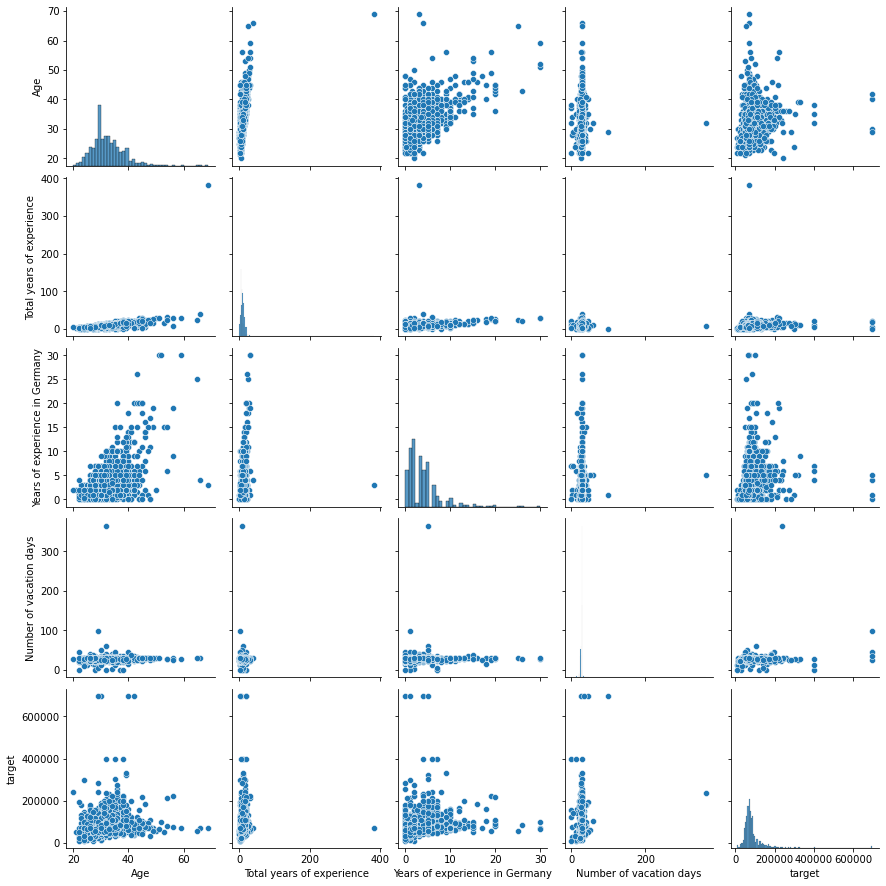

In [281]:
sns.pairplot(df)

import seaborn as sns
import matplotlib.pyplot as plt


### Categorical Plotting
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
sns.boxplot(x='Seniority level',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df,ax=ax[0,0])
sns.boxplot(x='Position ',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df ,ax=ax[0,1])
sns.boxplot(x='Total years of experience',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df ,ax=ax[1,0])
sns.boxplot(x='Gender',y='Yearly brutto salary (without bonus and stocks) in EUR',data=df ,ax=ax[1,1])

In [282]:
sns.kdeplot(data=df, x="Target")

ValueError: Could not interpret value `Target` for parameter `x`

In [ ]:
df['Target']=df['Target'].fillna(df['Target'].mean())

In [ ]:
y = df["Target"]
X = df.drop(columns={"Target"})

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import RandomForestClassifier 

#Tree Based
tree_sel = RandomForestClassifier().fit(X, y)
sfm_class = SelectFromModel(tree_sel, prefit=True)
x_new = sfm_class.transform(X)
print(x_new.shape)

mask = sfm_class.get_support()
new_features = X.columns[mask]
print(new_features)
###
post_mut_inf = SelectPercentile(score_func=mutual_info_classif, percentile=50).fit_transform(X,y.ravel())
print("Mutual Info:", post_mut_inf.shape)

#### Model
df2 = pd.get_dummies(df, drop_first=True)
y = np.array(df2["target"]).reshape(-1,1)
X = np.array(df2.drop(columns={"target"}))

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
print(clf.get_depth())
print(clf.score(X_test, y_test))
print(X.shape, y.shape)
plot_tree(clf)

# Generate a better image
from sklearn.tree import export_graphviz
export_graphviz(clf,
                     out_file="output/reg_tree_1.dot",
                     feature_names = df.drop(columns={"target"}).columns, 
                     class_names=["0","1"],
                     filled = True)
Regression Tree Decision Making

tree_para = {'min_samples_split':[2,3,4,5,6,7,8,9,10],
            'max_depth':[7,8,9,10,11,12,13,14,15,16], 
            'criterion':["friedman_mse", "poisson", "squared_error", "absolute_error"]}

clfCV = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), param_grid=tree_para, cv=10) #See below for the CV argument
clfCV.fit(X_train, y_train)
clfCV.best_estimator_


In [ ]:
def find_categorical_numerical(df):
    categorical = []
    numerical = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical.append(col)
        else:
            numerical.append(col)
    return categorical, numerical

In [ ]:
categorical, numerical = find_categorical_numerical(df)

In [ ]:
# Categorical data is 
print("categorical Data:")
categorical

categorical Data:


['Other technologies/programming languages you use often',
 'Yearly bonus + stocks in EUR',
 'Main language at work']

In [ ]:
# Numerical data is :
print("Numerical data:")
numerical

Numerical data:


['Age',
 'Gender',
 'City',
 'Position ',
 'Total years of experience',
 'Seniority level',
 'Your main technology / programming language',
 'Yearly brutto salary (without bonus and stocks) in EUR',
 'Number of vacation days',
 'Employment status',
 'Сontract duration',
 'Company size',
 'Company type',
 'Bonus',
 'Target',
 'Gender\t']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   Age                                                     1253 non-null   float64 
 1   Gender                                                  1253 non-null   category
 2   City                                                    1253 non-null   category
 3   Position                                                1253 non-null   category
 4   Total years of experience                               1253 non-null   category
 5   Seniority level                                         1253 non-null   category
 6   Your main technology / programming language             1253 non-null   category
 7   Other technologies/programming languages you use often  1253 non-null   object  
 8   Yearly brutto salary (withou

def replace_comma(df, column_name):    for i, row in df.iterrows():        value = row[column_name]        if isinstance(value, str):            df.at[i, column_name] = value.replace(',','.')        else:            df.at[i, column_name] = value

X.select_dtypes(exclude="object").columns

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder



# Select the best features using mutual information
y = df["Target"]
X = df.drop(columns={"Target"})
selector = SelectKBest(score_func=mutual_info_regression, k=5)
X = selector.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the categorical and numerical features
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

# Apply one-hot encoding to the categorical features and keep the numerical features as they are
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# Define the hyperparameters to search
param_grid = {'tree__max_depth': [2, 4, 6, 8, 10],
              'tree__min_samples_split': [2, 4, 6, 8, 10]}

# Train the decision tree model using grid search and one-hot encoding
regressor = DecisionTreeRegressor(random_state=0)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', regressor)
])
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Predict the salaries on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


ValueError: Input contains NaN


# Answers and Explainations
(Expand/modify as needed)

### Results

### Feature Selection Activities

### Hyperparameter Changes